In [2]:
import cPickle as pickle
import pandas as pd
import numpy as np
import random 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# local code
import sys
sys.path.insert(0, '/Users/zgreyn/Documents/galvanize/projects/nfl/src')
import combine
import clean
import scrape
import modeling

import itertools
import matplotlib
#import seaborn
%matplotlib inline

In [146]:
def plot_confusion_matrix_pretty(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Ex: plot_confusion_matrix_pretty(confusion_matrix(y, y_pred), ['KICK', 'PASS', 'RUSH'])
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(20,20)) 

In [170]:
# read in the prepped data
pbp = pd.read_csv('../data/pbp-training.csv')

In [172]:
# Combine the RUSHDIRECTION and PASSTYPE with the PLAY 
# (PLAY = PLAY + PASSTYPE or PLAY + RUSHDIRECTION)
def play_type_granular(x):
    if x.PLAY == 'RUSH':
        if not pd.isnull(x.RUSHDIRECTION):
            if x.RUSHDIRECTION.split(' ')[0] == 'QB':
                return 'RUSH: ' + x.RUSHDIRECTION
            else:
                return 'RUSH: ' + x.RUSHDIRECTION.split(' ')[0] # just keep the direction
        else:
            return 'RUSH: ' + x.PLAYTYPE
    if x.PLAY == 'PASS':
        if not pd.isnull(x.PASSTYPE):
            return 'PASS: ' + x.PASSTYPE
        else:
            return 'PASS: ' + x.PLAYTYPE
    if x.PLAY == 'KICK':
        return 'KICK: ' + x.PLAYTYPE
    else:
        return 'NaN'

In [173]:
pbp['PLAY'] = pbp.apply(lambda x: play_type_granular(x), axis=1)

In [169]:
pbp.PLAY.unique()

array(['RUSH: LEFT', 'PASS: SCRAMBLE', 'PASS: SACK', 'KICK: PUNT',
       'PASS: SHORT RIGHT', 'PASS: SHORT LEFT', 'PASS: SHORT MIDDLE',
       'RUSH: RIGHT', 'RUSH: QB KNEEL', 'RUSH: CENTER', 'PASS: DEEP RIGHT',
       'PASS: DEEP LEFT', 'KICK: FIELD GOAL', 'PASS: DEEP MIDDLE',
       'RUSH: FUMBLES', 'RUSH: DIRECT SNAP'], dtype=object)

In [174]:
columns_to_keep = [
    'CLOCK',
    #'QUARTER',
    #'MINUTE',
    #'SECOND',
    'DOWN',
    'TOGO',
    'YARDLINE',
    'SCORINGMARGIN',
    'ISTURF',
    'UNDERROOF',
    'ISATHOME',
    'TEMPERATURE',
    'HUMIDITY',
    'WINDSPEED',
    'SEASONYEAR',
    'PLAY']

formations = [
    'FIELD_GOAL',
    'NO_HUDDLE',
    'NO_HUDDLE_SHOTGUN',
    'PUNT',
    'SHOTGUN',
    'UNDER_CENTER',
    'WILDCAT']

teams = [
    'ARI',
    'ATL',
    'BAL',
    'BUF',
    'CAR',
    'CHI',
    'CIN',
    'CLE',
    'DAL',
    'DEN',
    'DET',
    'GB',
    'HOU',
    'IND',
    'JAX',
    'KC',
    'LA',
    'MIA',
    'MIN',
    'NE',
    'NO',
    'NYG',
    'NYJ',
    'OAK',
    'PHI',
    'PIT',
    'SD',
    'SEA',
    'SF',
    'TB',
    'TEN',
    'WAS']

def prep_records_granular(records, columns_to_keep=columns_to_keep, offense=True, defense=True, formation=True):
    '''
    INPUT: records - a set of plays as rows in a DataFrame in "clean form"
           columns_to_keep - the list of columns to keep in the result
           offense - True=Dummies for the offense, False=no offense feature
           formation - True=Dummies for the formation, False=no formation feature
    OUTPUT: The plays in "model form"
    '''

    # Fill missing values for HUMIDITY, TEMPERATURE, WINDSPEED and convert to int
    records.TEMPERATURE = records.TEMPERATURE.replace('UNKOWN', '75') # typo in earlier script
    records.HUMIDITY = records.HUMIDITY.replace('UNKNOWN', '45')
    records.WINDSPEED = records.WINDSPEED.replace('UNKNOWN', '0')
    records.WINDSPEED = records.WINDSPEED.replace('wind', '0') # odd parsing from earlier
    records.TEMPERATURE = records.TEMPERATURE.astype("int")
    records.HUMIDITY = records.HUMIDITY.astype("int")
    records.WINDSPEED = records.WINDSPEED.astype("int")

    # Map the class to integer
    class_map = {
        'RUSH: LEFT': 0, 
        'RUSH: RIGHT': 1,
        'RUSH: CENTER': 2,
        'RUSH: QB KNEEL': 3,
        'PASS: SCRAMBLE': 4, 
        'PASS: SACK': 5,
        'KICK: PUNT': 6, 
        'KICK: FIELD GOAL': 7,
        'PASS: SHORT RIGHT': 8, 
        'PASS: SHORT LEFT': 9, 
        'PASS: SHORT MIDDLE': 10, 
        'PASS: DEEP RIGHT': 11,
        'PASS: DEEP LEFT': 12,
        'PASS: DEEP MIDDLE': 13,
        'RUSH: FUMBLES': 14,
        'RUSH: DIRECT SNAP': 15,
        0:0,
        1:1,
        2:2,
        3:3,
        4:4,
        5:5,
        6:6,
        7:7,
        8:8,
        9:9,
        10:10,
        11:11,
        12:12,
        13:13,
        14:14,
        15:15
    }
    records['PLAY'] = records['PLAY'].map(class_map)

    # Convert the game clock to absolute seconds left in game
    records['CLOCK'] = 3600 - 900*records['QUARTER'] - 60*records['MINUTE'] - records['SECOND']

    # Dummy the offense team
    if offense:
        df2 = pd.get_dummies(records.OFFENSETEAM)
        dummies_frame = pd.get_dummies(teams)
        df2 = df2.reindex(columns=dummies_frame.columns, fill_value=0)
        df2.columns = map(lambda x: 'OFF_' + str(x), df2.columns)
    
    # Dummy the defense team
    if defense:
        df2 = pd.get_dummies(records.DEFENSETEAM)
        dummies_frame = pd.get_dummies(teams)
        df2 = df2.reindex(columns=dummies_frame.columns, fill_value=0)
        df2.columns = map(lambda x: 'DEF_' + str(x), df2.columns)

    # Dummy the formation
    if formation:
        df1 = pd.get_dummies(records.FORMATION)
        dummies_frame = pd.get_dummies(formations)
        df1 = df1.reindex(columns=dummies_frame.columns, fill_value=0)
        df1.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), df1.columns)

    # combine the dummy variables with any other column we're keeping
    if (offense and formation):
        records = pd.concat(
            [records.ix[:,columns_to_keep],
            df2,
            df1], axis=1)
    elif offense:
        records = pd.concat(
            [records.ix[:,columns_to_keep],
            df2], axis=1)
    elif formation:
        records = pd.concat(
            [records.ix[:,columns_to_keep],
            df1], axis=1)
    else:
        records = pd.concat(
            [records.ix[:,columns_to_keep]], axis=1)

    return records

In [175]:
pbp_prep = prep_records_granular(pbp)

In [176]:
gbc = modeling.create_model(pbp_prep)

In [177]:
# read in the cleaned validation data
pbp_v = pd.read_csv('../data/pbp-validation.csv')

In [178]:
pbp_v.drop(pbp_v.index[10468], inplace=True) # there's a bad record in there...
pbp_v['PLAY'] = pbp_v.apply(lambda x: play_type_granular(x), axis=1)

In [179]:
# run the prep (dummy out TEAM and FORMATION, keep only some of the columns, replace UNKNOWN values with 'indoor' defaults)
pbp_v_prep = prep_records_granular(pbp_v)

# split the class from the values
y = pbp_v_prep['PLAY']
X = pbp_v_prep.drop(['PLAY'], axis=1).values
col_names = pbp_v_prep.drop(['PLAY'], axis=1).columns

In [180]:
gbc.score(X, y)

0.31509216589861749

In [181]:
y_pred = gbc.predict(X)

In [182]:
classes = [
    'RUSH: LEFT', 
    'RUSH: RIGHT',
    'RUSH: CENTER',
    'RUSH: QB KNEEL',
    'PASS: SCRAMBLE', 
    'PASS: SACK',
    'KICK: PUNT', 
    'KICK: FIELD GOAL',
    'PASS: SHORT RIGHT', 
    'PASS: SHORT LEFT', 
    'PASS: SHORT MIDDLE', 
    'PASS: DEEP RIGHT',
    'PASS: DEEP LEFT',
    'PASS: DEEP MIDDLE',
    'RUSH: FUMBLES',
    'RUSH: DIRECT SNAP'
    ]

Confusion matrix, without normalization
[[ 577  368   86    9    0    0    0    2  347  106    7    0    0    0
     0    0]
 [ 576  371   80   15    0    0    0    1  297   79    1    0    0    0
     0    0]
 [ 306  237  154    9    0    0    1    4  278   91    5    0    0    0
     0    0]
 [   8    2    1  122    0    0    0    0    2    1    0    0    0    0
     0    0]
 [  24   21    8    1    0    0    0    1  132   46    5    0    0    0
     0    0]
 [  39   24    4    0    0    0    0    1  236   88    7    0    0    0
     0    0]
 [   0    0    0    0    0    0  833    0    0    0    0    0    0    0
     0    0]
 [   1    0    2    5    0    0    2  314    3    0    1    0    0    0
     0    0]
 [ 265  160   53    3    0    1    0    5 1015  418   32    0    0    0
     0    1]
 [ 236  171   59    0    0    0    1    1  897  408   24    0    0    0
     0    1]
 [ 114   87   33    3    0    0    2    5  649  285   35    0    0    0
     0    0]
 [  73   62   18    0    

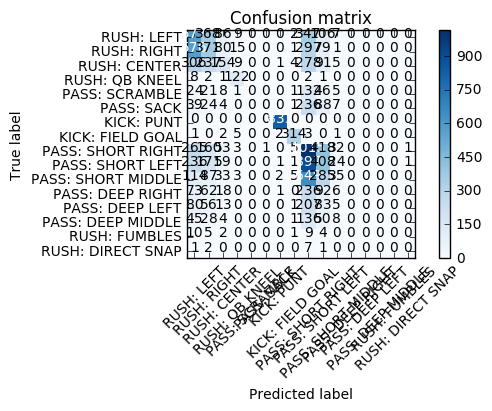

In [183]:
plot_confusion_matrix_pretty(confusion_matrix(y, y_pred), classes)

In [192]:
# pick a random play out of the data
rand_play = pd.DataFrame(pbp_v.iloc[random.randint(0,pbp_v.shape[0])]).T
rand_play

,index,GAMEID,GAMEDATE,QUARTER,MINUTE,SECOND,OFFENSETEAM,DEFENSETEAM,DOWN,TOGO,...,HOMETEAM,AWAYTEAM,HOMESCORE,AWAYSCORE,HUMIDITY,TEMPERATURE,WINDSPEED,ISATHOME,SCORINGMARGIN,CLOCK
6754,14615,2014102600,2014-10-26,3,12,55,DET,ATL,1,10,...,ATL,DET,21,0,0,59,13,0,-21,125


In [185]:
rand_play_prep = prep_records_granular(rand_play)

In [188]:
probas = gbc.predict_proba(rand_play_prep.drop(['PLAY'], axis=1).values)

In [191]:
zip(classes,probas[0])

[('RUSH: LEFT', 0.18750957130939641),
 ('RUSH: RIGHT', 0.16101887092116893),
 ('RUSH: CENTER', 0.12608886170213221),
 ('RUSH: QB KNEEL', 0.0009151080961138585),
 ('PASS: SCRAMBLE', 0.016891794900607993),
 ('PASS: SACK', 0.030313763495706903),
 ('KICK: PUNT', 4.9869931874802529e-05),
 ('KICK: FIELD GOAL', 0.00016526243315241403),
 ('PASS: SHORT RIGHT', 0.14081366610338858),
 ('PASS: SHORT LEFT', 0.12470367566514151),
 ('PASS: SHORT MIDDLE', 0.079639463788206327),
 ('PASS: DEEP RIGHT', 0.051464516776091561),
 ('PASS: DEEP LEFT', 0.047688420893995373),
 ('PASS: DEEP MIDDLE', 0.028599899129039295),
 ('RUSH: FUMBLES', 0.0028846996954878397),
 ('RUSH: DIRECT SNAP', 0.0012525551584960011)]

In [193]:
rand_play.DESCRIPTION

6754    (12:55) 38-G.WINN RIGHT GUARD TO ATL 48 FOR 2 ...
Name: DESCRIPTION, dtype: object